# DHHB 2021 Project: Classifying depressed patients using diurnal activity patterns

In this notebook, we make an analysis of activity data from depressed (condition) and non-depressed (control) subjects. 

First, the data is explored using visualisations and basic analysis. Then we do classification. 

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Importing data

In [2]:
# condition group data

path_cond =r'data/condition'
filenames_cond = glob.glob(path_cond + "/*.csv")

dfs_cond = []
for filename in filenames_cond:
    file = pd.read_csv(filename)

    # find the identifier from the file name
    person = filename[15:27]
    
    if person[(len(person)-1)].isdigit():
        pass
    else:
        person = person[:-1]
    
    # create a new column for identifying the person
    file['number'] = [person]*file.shape[0]
    
    dfs_cond.append(file)

# Concatenate all data into one DataFrame
df_condition = pd.concat(dfs_cond, ignore_index=True)

# control group data 

path_cont =r'data/control'
filenames_cont = glob.glob(path_cont + "/*.csv")

dfs_cont = []
for filename in filenames_cont:
    file = pd.read_csv(filename)

    # find the identifier from the file name
    person = filename[13:23]
    
    if person[(len(person)-1)].isdigit():
        pass
    else:
        person = person[:-1]
    
    # create a new column for identifying the person
    file['number'] = [person]*file.shape[0]
    dfs_cont.append(file)
    
# Concatenate all data into one DataFrame
df_control = pd.concat(dfs_cont, ignore_index=True)

dfs_cond and dfs_cont are lists that have all the individual activity dataframes for the condition and control group. df_control and and df_condition are DataFrames that have all the data from the corresponding group. 

In [3]:
# convert the date type from object to date
df_control["date"] = pd.to_datetime(df_control["date"])
df_condition["date"] = pd.to_datetime(df_condition["date"])
# convert the timestamp from object to datetime
df_control['timestamp'] = pd.to_datetime(df_control["timestamp"])
df_condition['timestamp'] = pd.to_datetime(df_condition["timestamp"])
# create hour column
df_control['hour'] = df_control['timestamp'].dt.hour
df_condition['hour'] = df_control['timestamp'].dt.hour



## Sufficient analytics

We calculate the metrics for the amount of days the subjects of both group were recorded. 

In [4]:
# stats of  recording days
stats = pd.DataFrame(columns=['Control', 'Condition'], index=['Mean', 'Std', 'Min', 'Max'])

days_control = np.zeros(len(dfs_cont))
days_condition = np.zeros(len(dfs_cond))

for i in range(len(dfs_cont)):
    # amount of days
    n = len(dfs_cont[i]['date'].value_counts())
    days_control[i] = n
    
for j in range(len(dfs_cond)):
    # amount of days
    n = len(dfs_cond[j]['date'].value_counts())
    days_condition[j] = n
    
stats['Control'] = [np.mean(days_control), np.std(days_control), np.min(days_control), np.max(days_control)]
stats['Condition'] = [np.mean(days_condition), np.std(days_condition), np.min(days_condition), np.max(days_condition)]
stats

,Control,Condition
Mean,23.093750,17.608696
Std,8.538001,3.931358
Min,15.000000,14.000000
Max,47.000000,30.000000


When the data has been recorded (in years)?

In [5]:
# check the years
df_control['date'].dt.year.value_counts()

2003    564088
2004    236439
2002    128335
2006     70638
2005     20490
Name: date, dtype: int64

Most of the data is from 2003 but other years as well. 

## Descriptive and explorative data analysis

It was required to do observations on both subject and group level. 

### Subject level

First we checked the activity per hours for one example from the control group as well as one example from the condition group. 

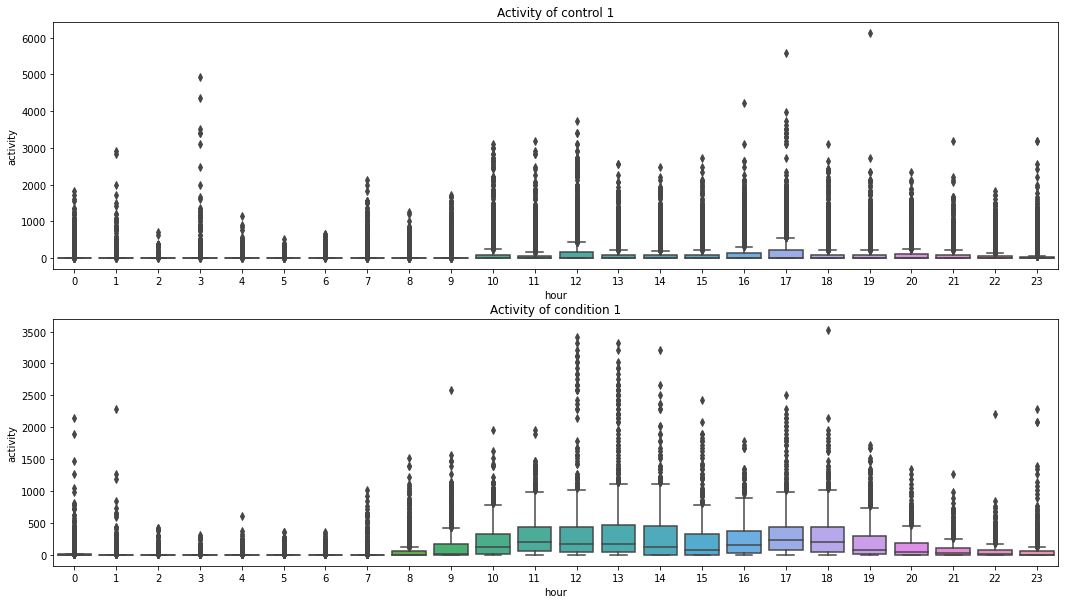

In [6]:
# subject level
df_control_1 = dfs_cont[0]
df_condition_1 = dfs_cond[0]

fig, axes = plt.subplots(2, 1, figsize=(18, 10))
df_control_1['timestamp'] = pd.to_datetime(df_control_1["timestamp"])
df_control_1['hour'] = df_control_1['timestamp'].dt.hour

# make the plot
sns.boxplot(x='hour', y='activity', data=df_control_1, ax = axes[0])
axes[0].set_title('Activity of control 1')

df_condition_1['timestamp'] = pd.to_datetime(df_condition_1["timestamp"])
df_condition_1['hour'] = df_condition_1['timestamp'].dt.hour

# make the plot
sns.boxplot(x='hour', y='activity', data=df_condition_1, ax = axes[1])
axes[1].set_title('Activity of condition 1')
plt.show()

The plot above don't tell very much despite that can see that there are lot of variation and outliers.

Next we show the whole recorded activity by dates for the same subjects. 

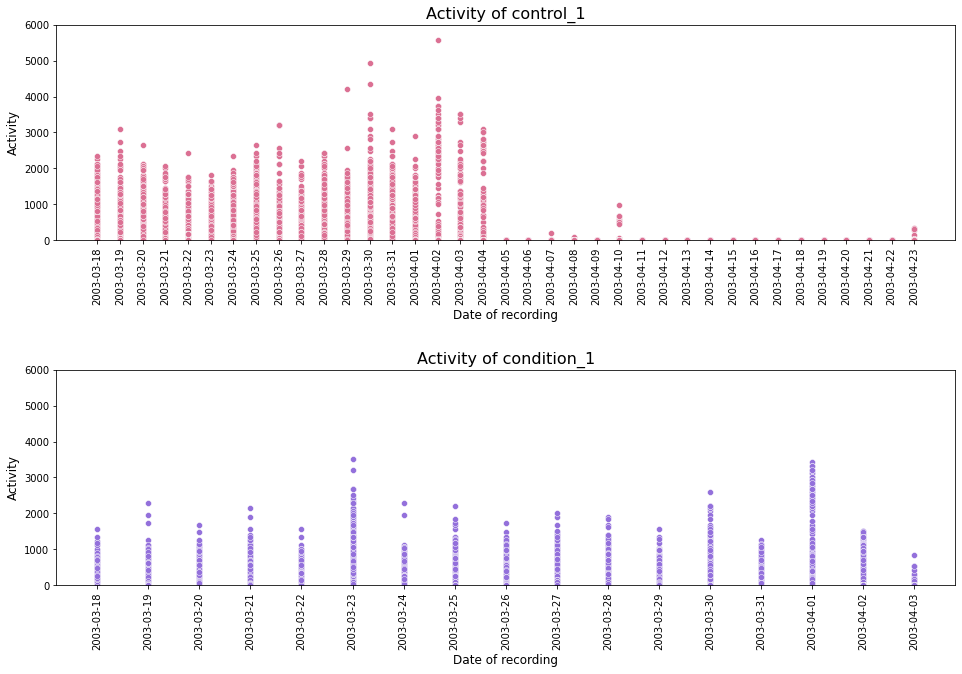

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# convert the dates into datetime as well
df_control_1['date'] = pd.to_datetime(df_control_1['date'])
df_condition_1['date'] = pd.to_datetime(df_control_1['date'])

# make the plot for control group
sns.scatterplot(x='date', y='activity', data=df_control_1, ax = axes[0], color='palevioletred')
axes[0].set_title('Activity of control_1', fontsize=16)
axes[0].set_ylim([0,6000])
axes[0].set_ylabel("Activity", fontsize=12)
axes[0].set_xlabel("Date of recording", fontsize=12)

days_cont = df_control_1['date'].value_counts().index.sort_values().to_series()
axes[0].set_xticks(ticks=np.arange(12129,12166))
axes[0].set_xticklabels(labels=days_cont.dt.date, rotation=90)

# and for condition group
sns.scatterplot(x='date', y='activity', data=df_condition_1, ax = axes[1], color="mediumpurple")
axes[1].set_title('Activity of condition_1', fontsize=16)
axes[1].set_ylim([0,6000])
axes[1].set_ylabel("Activity", fontsize=12)
axes[1].set_xlabel("Date of recording", fontsize=12)

days_cond = df_condition_1['date'].value_counts().index.sort_values().to_series()
axes[1].set_xticks(ticks=np.arange(12129,12146))
axes[1].set_xticklabels(labels=days_cond.dt.date, rotation=90)

fig.tight_layout(pad=3.0)
plt.show()

### Group level

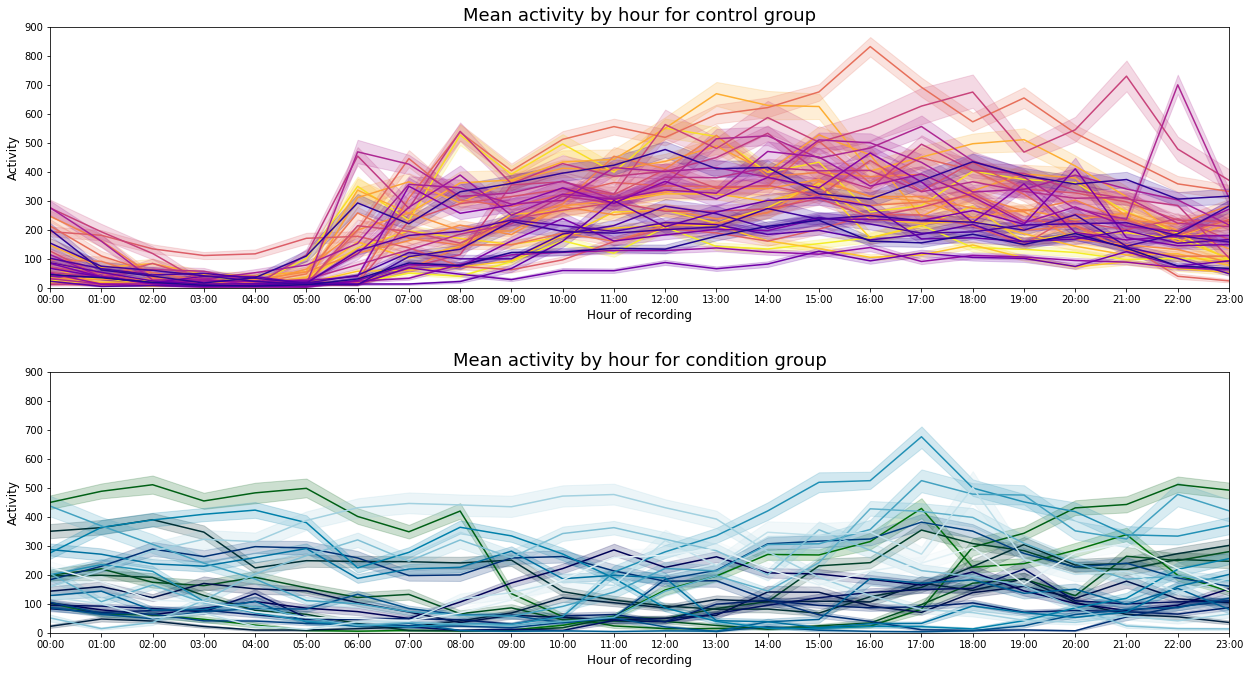

In [8]:
# lineplot
labels = ["00:00", "01:00", "02:00", "03:00", "04:00", "05:00", "06:00", "07:00",
         "08:00", "09:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00",
         "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"]

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

#plt.setp(axes, xticks=np.arange(24), xticklabels=labels)

#sns.lineplot(data=means_control, x="hour", y="mean activity", hue="number", ax=axes[0])
line1 = sns.lineplot(data=df_control, x="hour", y="activity", hue="number", ax=axes[0], palette='plasma_r')
axes[0].set_title("Mean activity by hour for control group", fontsize=18)
axes[0].set_ylim([0,900])
axes[0].set_ylabel("Activity", fontsize=12)
axes[0].set_xlabel("Hour of recording", fontsize=12)
axes[0].set_xticks(ticks=np.arange(24))
axes[0].set_xticklabels(labels=labels)
axes[0].margins(x=0)

# don't show legend
axes[0].legend([],[], frameon=False)

line2 =sns.lineplot(data=df_condition, x="hour", y="activity", hue="number", ax=axes[1], palette='ocean')
line2.legend_.remove()
axes[1].set_title("Mean activity by hour for condition group", fontsize=18)
#plt.yticks(ticks=np.arange(0,801,100))
axes[1].set_ylim([0,900])
axes[1].set_ylabel("Activity", fontsize=12)
axes[1].set_xlabel("Hour of recording", fontsize=12)
axes[1].set_xticks(ticks=np.arange(24))
axes[1].set_xticklabels(labels=labels)
axes[1].margins(x=0)

fig.tight_layout(pad=3.0)
plt.show()

## Classification

### Reducing features

Based on the visualizations above, can we spot the times when there is differences between the control and condition group?
Let's first do only night and day. 

In [9]:
# can we first do only night and day and plot it to see if there are clusters?
# let's do day = 6-18 and night = 18-6
df_2_features = pd.DataFrame(columns=['day activity', 'night activity', 'group'])

for i in range(len(dfs_cond)):
    name = "condition_" + str(i+1)
    index_day = df_condition[(df_condition['number']==name)&((df_condition['hour']>=6) & (df_condition['hour']<18))].index
    mean_day = df_condition.iloc[index_day]['activity'].mean()
    index_night = df_condition[(df_condition['number']==name)&((df_condition['hour']< 6) | (df_condition['hour']>=18))].index
    mean_night = df_condition.iloc[index_night]['activity'].mean()
    df_2_features = df_2_features.append(pd.DataFrame({'day activity':[mean_day], 'night activity': [mean_night], 
                                              'group': "condition"}), ignore_index=True)
    

for j in range(len(dfs_cont)):
    name= "control_" + str(j+1)
    index_day = df_control[(df_control['number']==name)&((df_control['hour']>=6) & (df_control['hour']<18))].index
    mean_day = df_control.iloc[index_day]['activity'].mean()
    
    index_night = df_control[(df_control['number']==name)&((df_control['hour']< 6) | (df_control['hour']>=18))].index
    mean_night = df_control.iloc[index_night]['activity'].mean()
    
    df_2_features = df_2_features.append(pd.DataFrame({'day activity':[mean_day], 'night activity': [mean_night], 
                                              'group': "control"}), ignore_index=True)

In [10]:
df_2_features.head()

,day activity,night activity,group
0,147.893248,145.990038,condition
1,158.316440,148.959694,condition
2,257.852323,272.780185,condition
3,201.605058,347.830463,condition
4,148.403535,185.901759,condition


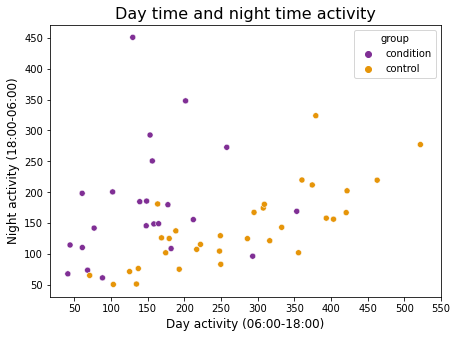

In [11]:
fig = plt.figure(figsize=(7, 5))
sns.scatterplot(x='day activity', y='night activity', hue='group', data=df_2_features, palette='CMRmap')
plt.ylabel("Night activity (18:00-06:00)", fontsize=12)
plt.xlabel("Day activity (06:00-18:00)", fontsize=12)
plt.xticks(np.arange(50, 560, 50))
plt.title("Day time and night time activity", fontsize=16)
plt.show()

We can see that condition group has lower day activity and higher night activity whereas the control group has smaller night activity and higher day activity. 

Let's do four categories: night, morning, day and evening. 


In [12]:
# night 00:00-5:00, morning 5:00-9:00, day 9:00-16:00, evening 16:00-00:00
intervals = [[0,5], [5,9], [9,16], [16,24]]

def time_bins(n, data, results, depressed=True):
    # check whether condition or control group
    if depressed:
        group = "condition_"
        value = 1
        
    else:
        group = "control_"
        value =0
    
    for i in range(n):
        name = group + str(i+1)
        
        values = np.zeros(shape=(1, (len(intervals)+1)))
        
        for j, points in enumerate(intervals):
            index = data[(data['number']==name)&((data['hour']>=points[0]) & (data['hour']<points[1]))].index
            values[0][j] = data.iloc[index]['activity'].mean()
        
        values[0][4] = value

        results = results.append(pd.DataFrame(values, 
                                              columns=['night activity', 'morning activity', 
                                                        'day activity', 'evening activity', 'depressed']), 
                                 ignore_index=True)
    
    return results 

In [13]:
df_4_features = pd.DataFrame(columns=['night activity', 'morning activity', 'day activity', 'evening activity', 'depressed'])
# add condition group
df_4_features = time_bins(len(dfs_cond), df_condition, df_4_features)
# add control group
df_4_features = time_bins(len(dfs_cont), df_control, df_4_features, False)
df_4_features['depressed'] = df_4_features['depressed'].astype(int)

In [14]:
scaler = MinMaxScaler()
df_4_features_scaled = df_4_features
df_4_features_scaled[['night activity', 'morning activity', 'day activity', 'evening activity']] = scaler.fit_transform(df_4_features[['night activity', 'morning activity', 'day activity', 'evening activity']])

In [15]:
df_4_features_scaled.head()

,night activity,morning activity,day activity,evening activity,depressed
0,0.107878,0.000000,0.231082,0.450446,1
1,0.115020,0.047136,0.267060,0.442525,1
2,0.331751,0.053180,0.454951,0.796109,1
3,0.636738,0.188445,0.317077,0.748152,1
4,0.266210,0.067503,0.192708,0.492203,1


### Cross-validation and classification

In [16]:
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1], 'precision': precision_score(y, y_pred),
           'recall': recall_score(y, y_pred), 'accuracy' : accuracy_score(y, y_pred), 'f1':f1_score(y, y_pred)}

In [17]:
X = df_4_features_scaled[['night activity', 'morning activity', 'day activity', 'evening activity']].to_numpy()
y = df_4_features_scaled['depressed'].to_numpy()

# cross validation
metrics = pd.DataFrame(columns=["true negative", "false positive", "false negative",
                               'true positive', 'precision', 'recall', 'accuracy', 'f1 score'], 
                      index=['KNN', 'Random Forest', 'Decision Tree', 'SVC'])

clfs = {'KNN':KNeighborsClassifier(), 'Random Forest':RandomForestClassifier(random_state=0), 
         'Decision Tree':DecisionTreeClassifier(random_state=0), 'SVC': SVC(random_state=0)}

for clf in clfs:
    scores = cross_validate(clfs[clf], X, y, scoring=custom_scorer)
    #scores.keys()
    metrics.loc[clf] = [np.mean(scores['test_tn']), np.mean(scores['test_fp']), np.mean(scores['test_fn']), 
                        np.mean(scores['test_tp']), np.mean(scores['test_precision']), np.mean(scores['test_recall']),
                       np.mean(scores['test_accuracy']), np.mean(scores['test_f1'])]


## Evaluating metrics of the classification



In [18]:
metrics

,true negative,false positive,false negative,true positive,precision,recall,accuracy,f1 score
KNN,6.0,0.4,1.0,3.6,0.91,0.79,0.872727,0.833333
Random Forest,5.8,0.6,1.4,3.2,0.88,0.72,0.818182,0.744127
Decision Tree,5.4,1.0,0.8,3.8,0.813333,0.84,0.836364,0.807778
SVC,5.8,0.6,1.2,3.4,0.86,0.75,0.836364,0.788889
